<a href="https://colab.research.google.com/github/Elangoraj/LandCover-Image-Classification/blob/main/LandCover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download images**

In [ ]:
!mkdir Dataset
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip 
!unzip /content/EuroSAT.zip
!mv /content/2750/ /content/Dataset/

In [2]:
# !wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
# !unzip /content/UCMerced_LandUse.zip

**Prepare data**

In [3]:
# Import libraries
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
base_path = '/content/Dataset/2750'

LABELS = os.listdir(base_path)
print('Class labels',LABELS)

Class labels ['Industrial', 'Pasture', 'AnnualCrop', 'River', 'HerbaceousVegetation', 'Residential', 'PermanentCrop', 'SeaLake', 'Highway', 'Forest']


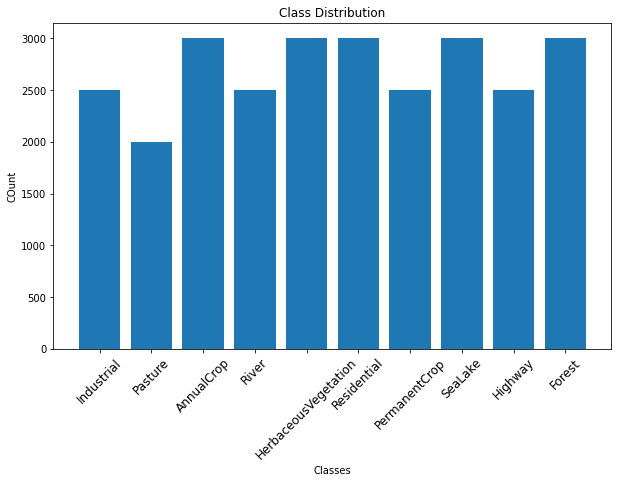

In [18]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(base_path, l)))

    
plt.figure(figsize=(10, 6))

plt.bar(range(len(counts)), list(counts.values()))
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=45)
plt.xlabel('Classes')
plt.ylabel('COunt')
plt.title('Class Distribution');

Training images


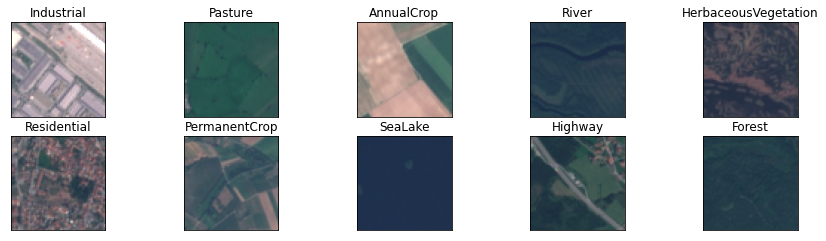

In [19]:
img_paths = [os.path.join(base_path, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(base_path, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

print('Training images')
plot_sat_imgs(img_paths)

In [7]:
# !rm -r TRAIN_DIR
# !rm -r TEST_DIR
!rm -r /content/UCMerced_LandUse/test
!rm -r /content/UCMerced_LandUse/train

rm: cannot remove '/content/UCMerced_LandUse/test': No such file or directory
rm: cannot remove '/content/UCMerced_LandUse/train': No such file or directory


In [8]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

# !rm -r TRAIN_DIR
# !rm -r TEST_DIR
TRAIN_DIR = '/content/Dataset/train/'
TEST_DIR = '/content/Dataset/test/'
TRAIN_DIR = "{}".format(TRAIN_DIR)
TEST_DIR = "{}".format(TEST_DIR)

!mkdir '/content/Dataset/train'
!mkdir '/content/Dataset/test'

BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

In [9]:
# create class label subdirectories in train and test
for l in LABELS:
    # print(l)
    if not os.path.exists(TRAIN_DIR+l):
        os.mkdir(TRAIN_DIR+l)

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(TEST_DIR+l)

In [10]:
# Split data for train and test images
data = {}

for l in LABELS:
    for img in os.listdir(base_path+'/'+l):
        data.update({os.path.join(base_path, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)


for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    new_train_paths = [re.sub('/content/Dataset/2750', '/content/Dataset/train', i) for i in train_paths]
    new_test_paths = [re.sub('/content/Dataset/2750', '/content/Dataset/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    print("moving training files..")
    for i in tqdm(train_path_map):
      
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  3%|▎         | 670/21600 [00:00<00:03, 6694.48it/s]

moving training files..


 14%|█▎        | 731/5400 [00:00<00:00, 7303.76it/s]

moving testing files..


100%|██████████| 5400/5400 [00:00<00:00, 6801.33it/s]


In [20]:
#  Train and test generator set 
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [21]:
print(train_generator.class_indices)
np.save('class_indices', train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
